   #   `Business Case: Zee Recommender Systems`

## 1. <font color='blue'> Define Problem Statement and Formatting the Data</font>

###	 Business Problem
<font color='Blue'>
    
Create a Recommender System to show personalized movie recommendations based on ratings <br> given by a user and other users similar to them in order to improve user experience.
</font>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore")

### Reading the Data Files:-

In [26]:
movies =  pd.read_fwf('C:/Scaler_DSML/Project/Zee Recommender Systems/zee-movies.dat', encoding='ISO-8859-1')
ratings = pd.read_fwf('C:/Scaler_DSML/Project/Zee Recommender Systems/zee-ratings.dat', encoding='ISO-8859-1')
users =   pd.read_fwf('C:/Scaler_DSML/Project/Zee Recommender Systems/zee-users.dat', encoding='ISO-8859-1')

In [27]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Movie ID::Title::Genres  3883 non-null   object
 1   Unnamed: 1               100 non-null    object
 2   Unnamed: 2               51 non-null     object
dtypes: object(3)
memory usage: 91.1+ KB


In [28]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 1 columns):
 #   Column                              Non-Null Count    Dtype 
---  ------                              --------------    ----- 
 0   UserID::MovieID::Rating::Timestamp  1000209 non-null  object
dtypes: object(1)
memory usage: 7.6+ MB


In [29]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 1 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   UserID::Gender::Age::Occupation::Zip-code  6040 non-null   object
dtypes: object(1)
memory usage: 47.3+ KB


#### -----------------------------------------------------------------------------------------------

## > Analyzing basic metrics of row data received
<br>

<font color='Blue'>    
1. Shape of movies: Total of 3882 rows × 3 columns<br>
2. Shape of ratings: Total of 1000209 rows × 1 columns<br>
3. Shape of users: Total of 6039 rows × 1 columns
</font>

## > Data Formatting

### Movies

In [30]:
movies.head()

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [31]:
movies.drop(columns=['Unnamed: 1','Unnamed: 2'], axis=1, inplace=True)

In [32]:
delimiter = '::'
movies = movies['Movie ID::Title::Genres'].str.split(delimiter, expand=True)
movies.columns=['Movie ID','Title','Genres']

In [33]:
movies.rename(columns={'Movie ID':'MovieID'}, inplace=True)

In [34]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


### Ratings

In [35]:
ratings.head(2)

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109


In [36]:
ratings = ratings['UserID::MovieID::Rating::Timestamp'].str.split(delimiter, expand=True)
ratings.columns=['UserID','MovieID','Rating','Timestamp']
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### Users

In [37]:
users.head(2)

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072


In [38]:
users = users['UserID::Gender::Age::Occupation::Zip-code'].str.split(delimiter, expand=True)
users.columns=['UserID','Gender','Age','Occupation','Zip-code']
users.head(3)

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117


In [39]:
users.replace(
            {'Age':{'1': "Under 18",
                    '18':"18-24",
                    '25':"25-34",
                    '35':"35-44",
                    '45':"45-49",
                    '50':"50-55",
                    '56':"56 Above"}}
            ,inplace=True)

In [40]:
users.replace({'Occupation':{
            '0': "other",
            '1': "academic/educator",
            '2': "artist",
            '3': "clerical/admin",
            '4': "college/grad student",
            '5': "customer service",
            '6': "doctor/health care",
            '7': "executive/managerial",
            '8': "farmer",
            '9': "homemaker",
            '10': "K-12 student",
            '11': "lawyer",
            '12': "programmer",
            '13': "retired",
            '14': "sales/marketing",
            '15': "scientist",
            '16': "self-employed",
            '17': "technician/engineer",
            '18': "tradesman/craftsman",
            '19': "unemployed",
            '20': "writer"}}
            ,inplace=True)

In [41]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,Under 18,K-12 student,48067
1,2,M,56 Above,self-employed,70072
2,3,M,25-34,scientist,55117
3,4,M,45-49,executive/managerial,02460
4,5,M,25-34,writer,55455


### Merging the DataFrames :

In [42]:
df1 = pd.merge(movies,ratings, how='inner', on='MovieID')

In [43]:
df2 = pd.merge(df1,users, how='inner', on='UserID')
df2

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,Under 18,K-12 student,48067
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,Under 18,K-12 student,48067
2,150,Apollo 13 (1995),Drama,1,5,978301777,F,Under 18,K-12 student,48067
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantas,1,4,978300760,F,Under 18,K-12 student,48067
4,527,Schindler's List (1993),Drama|War,1,5,978824195,F,Under 18,K-12 student,48067
...,...,...,...,...,...,...,...,...,...,...
1000204,3513,Rules of Engagement (2000),Drama|Thriller,5727,4,958489970,M,25-34,college/grad student,92843
1000205,3535,American Psycho (2000),Comedy|Horror|Thriller,5727,2,958489970,M,25-34,college/grad student,92843
1000206,3536,Keeping the Faith (2000),Comedy|Romance,5727,5,958489902,M,25-34,college/grad student,92843
1000207,3555,U-571 (2000),Action|Thriller,5727,3,958490699,M,25-34,college/grad student,92843


## 2. <font color='blue'> Performing EDA, Data Cleaning, and Feature Engineering</font>

In [44]:
df2['ReleaseYear'] = df2.Title.str.slice(start=-5,stop=-1)

In [45]:
df2[df2.columns[-6:]].head()

,Timestamp,Gender,Age,Occupation,Zip-code,ReleaseYear
0,978824268,F,Under 18,K-12 student,48067,1995
1,978824351,F,Under 18,K-12 student,48067,1995
2,978301777,F,Under 18,K-12 student,48067,1995
3,978300760,F,Under 18,K-12 student,48067,1977
4,978824195,F,Under 18,K-12 student,48067,1993


In [46]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 11 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   MovieID      1000209 non-null  object
 1   Title        1000209 non-null  object
 2   Genres       996144 non-null   object
 3   UserID       1000209 non-null  object
 4   Rating       1000209 non-null  object
 5   Timestamp    1000209 non-null  object
 6   Gender       1000209 non-null  object
 7   Age          1000209 non-null  object
 8   Occupation   1000209 non-null  object
 9   Zip-code     1000209 non-null  object
 10  ReleaseYear  1000209 non-null  object
dtypes: object(11)
memory usage: 91.6+ MB


### Identifying the `Missing values` across the all variables: 

* since only 4% of Genres are null we can drop the rows. 

In [47]:
df2[df2.columns[df2.isnull().any()]].isnull().sum() * 100 / df2.shape[0]

Genres    0.406415
dtype: float64

In [48]:
df2.dropna(inplace=True)

### Count duplicate rows on entire dataframe:

In [49]:
len(df2)-len(df2.drop_duplicates())

0

### Checking the unique value counts in columns

In [50]:
data = df2
featureValues={}
for d in data.columns.tolist():
    count=data[d].nunique()
    if count==1:
        featureValues[d]=count
# List of columns having same 1 unique value        
cols_to_drop= list(featureValues.keys())
print("Columns having 1 unique value are :",cols_to_drop)

Columns having 1 unique value are : []


In [51]:
# df2['Rating'] = df2['Rating'].astype('int64')
# df2['Rating'].info()

In [52]:
df2.describe()

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,ReleaseYear
count,996144,996144,996144,996144,996144,996144,996144,996144,996144,996144,996144
unique,3682,3682,358,6040,5,457632,2,7,21,3439,81
top,2858,American Beauty (1999),Comedy,4169,4,975528402,M,25-34,college/grad student,94110,1999
freq,3428,3428,116691,2303,347758,30,750590,394105,130626,3782,86833


### Gender
##### Updating Gender 'M', 'F' to '0', '1' codes.
* M = 0, F= 1
* 75 % are males, 25 % Female users.

In [53]:
df2['Gender'] = df2['Gender'].apply(lambda s: '0' if s=='M' else '1')

0    75.349548
1    24.650452
Name: Gender, dtype: float64

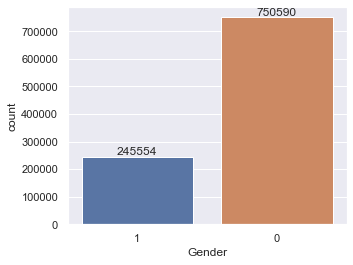

In [54]:
sns.set(rc={'figure.figsize':(5,4)})
ax = sns.countplot(data=df2,x="Gender")
ax.bar_label(container=ax.containers[0])
df2['Gender'].value_counts(normalize=True)*100

## Rating
* 4 is the most given rating
* Rating range from 1 to 5


4    34.910415
3    26.148127
5    22.550856
2    10.767620
1     5.622982
Name: Rating, dtype: float64

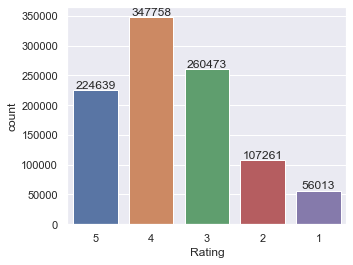

In [55]:
ax = sns.countplot(data=df2,x="Rating")
ax.bar_label(container=ax.containers[0])
df2['Rating'].value_counts(normalize=True)*100

## 'Title' variable
### Top 30 most watched movies
* American Beauty (1999) is most watched movie 3428 times.
* Total of 3682 unique movie/content is available. 

<AxesSubplot:>

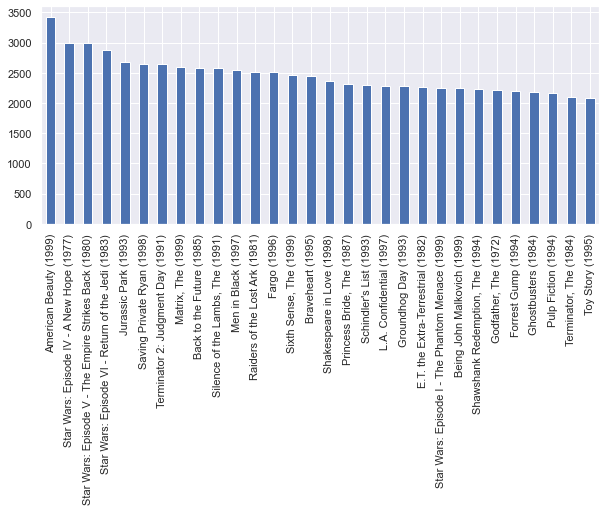

In [56]:
df2['Title'].value_counts().head(30).plot(kind='bar',figsize=(10, 4))

In [57]:
def with_hue(ax, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in ax.patches]
    patch = [p for
             p in ax.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)
            
# example : with_hue(ax,g1.Content_Type,2,2)

def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 4 - 0.02
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)

## Age
* 25-35 group has most users( 40%) followed by 35-44 group (20%).
* Under 18 has least amount of users.

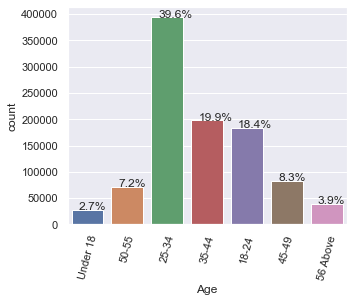

In [58]:
ax = sns.countplot(data=df2,x="Age")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 75)
without_hue(ax,df2.Age)

## Occupation
* college/grad student and other users are 13%
* Farmer, homemaker, tradesman, unemployed, retired are least users. 

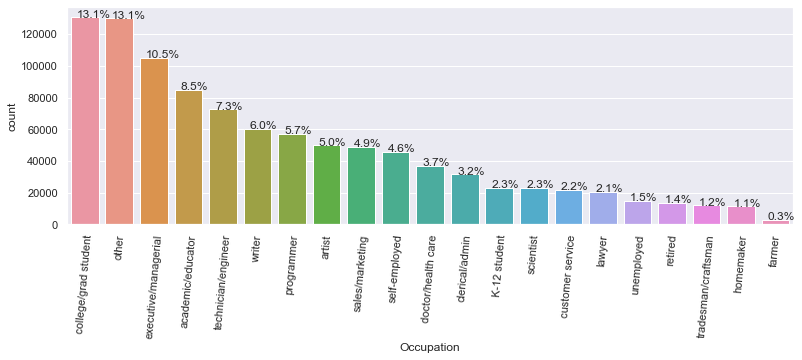

In [59]:
sns.set(rc={'figure.figsize':(13,4)})
ax = sns.countplot(data=df2,x="Occupation", order = df2['Occupation'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 85)
without_hue(ax,df2.Occupation)

## Zip-code
* Top 25 Zip-code

<AxesSubplot:>

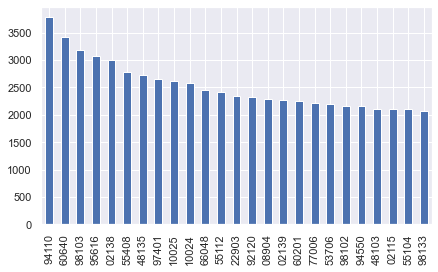

In [60]:
df2['Zip-code'].value_counts().head(25).plot(kind='bar',figsize=(7, 4))

## Release Year
* Most release year movies are between 1993 to 1999.
* Min release year 1919 and Max release year is 2020.

<AxesSubplot:>

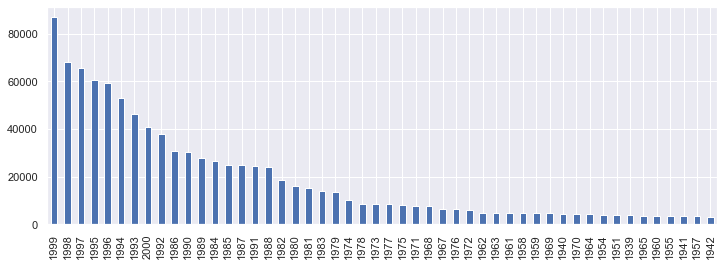

In [61]:
df2['ReleaseYear'].value_counts().head(50).plot(kind='bar',figsize=(12, 4))

In [62]:
df2['ReleaseYear'].min(),df2['ReleaseYear'].max()

('1919', '2000')

## Genres

In [63]:
df2[['MovieID','Genres']]

,MovieID,Genres
0,1,Animation|Children's|Comedy
1,48,Animation|Children's|Musical|Romance
2,150,Drama
3,260,Action|Adventure|Fantas
4,527,Drama|War
...,...,...
1000204,3513,Drama|Thriller
1000205,3535,Comedy|Horror|Thriller
1000206,3536,Comedy|Romance
1000207,3555,Action|Thriller


In [64]:
g= df2['Genres'].apply(lambda x: str(x).split('|')).tolist()

In [65]:
g1 = pd.DataFrame(g, index=df2['Title'])
g1 = g1.stack()
g1 = g1.reset_index()
g1.rename(columns={0:'Content_Type'}, inplace=True)
g1.drop(['level_1'],axis=1, inplace=True)
g1

,Title,Content_Type
0,Toy Story (1995),Animation
1,Toy Story (1995),Children's
2,Toy Story (1995),Comedy
3,Pocahontas (1995),Animation
4,Pocahontas (1995),Children's
...,...,...
2060026,Keeping the Faith (2000),Romance
2060027,U-571 (2000),Action
2060028,U-571 (2000),Thriller
2060029,Gladiator (2000),Action


In [66]:
g1 = g1[~(g1.Content_Type == '')]
g1.Content_Type.value_counts().index.tolist()

['Comedy',
 'Drama',
 'Action',
 'Thriller',
 'Romance',
 'Sci-Fi',
 'Adventure',
 'Crime',
 'Horror',
 "Children's",
 'War',
 'Animation',
 'Musical',
 'Mystery',
 'Fantasy',
 'Western',
 'Film-Noir',
 'Documentary',
 'Fantas',
 'Adv',
 'Adventu',
 'Sci-F',
 'Sci-',
 'Adventur',
 "Children'",
 'Th',
 'Fant',
 'R',
 'S',
 'Dr',
 'Ro',
 'Horro',
 'Music',
 'Dram',
 'Sci',
 'A',
 'D',
 'Wester',
 'Thri',
 'Rom',
 'Come',
 'Docu',
 'Childre',
 'Children',
 'Wa',
 'Chi',
 'F',
 'Com',
 'Roman',
 'Advent',
 'We',
 'Documenta',
 'Roma',
 'Thrille',
 'Comed',
 'Animati',
 'Chil',
 'Childr',
 'Document',
 'Acti',
 'Horr',
 'Documen']

### Using replace and str.startswith() in a pandas dataframe to rename values.
<font color='Blue'>
<br>
* Cleaning 'Genres' to find percentage of each 'Genre'.<br>
* Using dictionary to cleanup names.
</font>


In [67]:
d = {"Ch": 'Childrens', 
     'Ad': 'Adventure',
     'Do':'Documentary',
     'Ho':'Horror',
     'Ac':'Action',
     'Co':'Comedy',
     'Th':'Thriller',
     'We':'Western',
     'Ro':'Romance',
     'F':'Fantasy',
     'Wa':'War',
     'Dr':'Drama',
     'S':'Sci-Fi',
     'Ani':'Animation'}

for k, v in d.items():
    g1.loc[g1.Content_Type.str.startswith(k, na=False), 'Content_Type'] = v

In [68]:
g1.Content_Type = g1.Content_Type.replace(['A'], 'Action')
g1.Content_Type = g1.Content_Type.replace(['D'], 'Drama' )
g1.Content_Type = g1.Content_Type.replace(['R'], 'Romance')
g1.Content_Type.value_counts()

Comedy         353555
Drama          350056
Action         257174
Thriller       188501
Romance        142275
Sci-Fi         142072
Adventure      133342
Crime           79387
Horror          76267
Childrens       71887
War             61056
Fantasy         50427
Animation       42948
Musical         40653
Mystery         39550
Western         20683
Documentary      7799
Music             763
Name: Content_Type, dtype: int64

In [69]:
g1 = g1.drop_duplicates()
g2 = g1.copy()

In [70]:
g1.head(3)

,Title,Content_Type
0,Toy Story (1995),Animation
1,Toy Story (1995),Childrens
2,Toy Story (1995),Comedy


In [71]:
# concatenate the string
g2.Content_Type = g2.groupby(['Title'])['Content_Type'].transform(lambda x : ' '.join(x))
g2 = g2.drop_duplicates()
g2.head()

,Title,Content_Type
0,Toy Story (1995),Animation Childrens Comedy
3,Pocahontas (1995),Animation Childrens Musical Romance
7,Apollo 13 (1995),Drama
8,Star Wars: Episode IV - A New Hope (1977),Action Adventure Fantasy
11,Schindler's List (1993),Drama War


In [72]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(g2.Content_Type)

In [73]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [74]:
# Reset index of our main DataFrame and construct reverse mapping as before
g2 = g2.reset_index()
indices = pd.Series(g2.index, index=g2['Title'])

 ## <font color='blue'> Function to return top 5 recommendations for a given Item / Movie </font>

In [75]:
# Function that takes in movie title as input and outputs most similar movies
cosine_sim= ''
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 5 most similar movies
    sim_scores = sim_scores[1:6]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return g2['Title'].iloc[movie_indices]

In [76]:
get_recommendations('Toy Story (1995)', cosine_sim2)

40                       Bug's Life, A (1998)
50                         Toy Story 2 (1999)
289                        Chicken Run (2000)
629    Aladdin and the King of Thieves (1996)
674                  American Tail, An (1986)
Name: Title, dtype: object

In [77]:
get_recommendations('Liar Liar (1997)', cosine_sim2)

45                    Airplane! (1980)
48     Ferris Bueller's Day Off (1986)
95                   Moonstruck (1987)
100                     28 Days (2000)
231               High Fidelity (2000)
Name: Title, dtype: object

### Comments on Genres
<font color='Blue'>
<br>
* Drama is most watched genres 24%, followed by Comedy with 18.8 % content. <br>
* Action is 3rd  most watched with 8.1% content.<br>
* Music, Western are least watched Genres with less then 1% viewers.
</font>

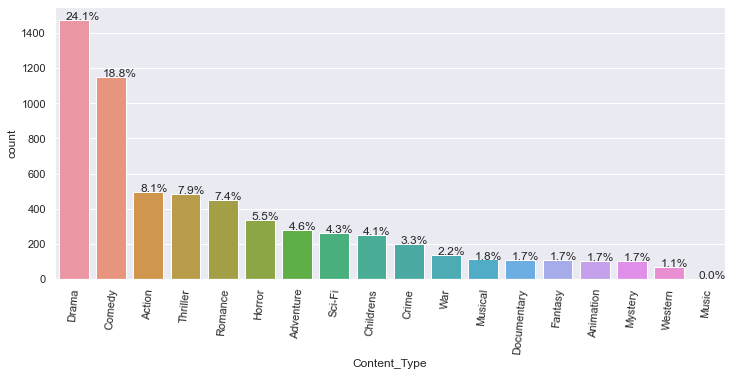

In [78]:
sns.set(rc={'figure.figsize':(12,5)})
ax = sns.countplot(data=g1,x="Content_Type", order = g1['Content_Type'].value_counts().index)
# ax.bar_label(container=ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 85)
without_hue(ax,g1.Content_Type)

## 'UserID'
* Top 20 user.

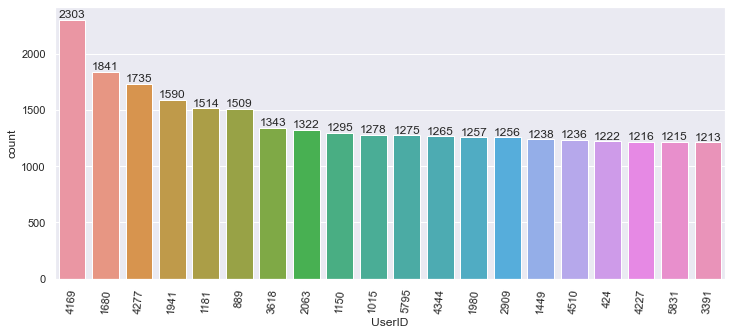

In [79]:
sns.set(rc={'figure.figsize':(12,5)})
ax = sns.countplot(data=df2,x="UserID", order = df2['UserID'].value_counts().head(20).index)
ax.bar_label(container=ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 85);

## `Grouping in terms of Average Rating and No. of Ratings given`
<br>
<font color='blue'>

### 1. Below 'm' dataFrame list out Movies based on Mean Rating <br>and having 'Percentage_rating' above 2%
### 2. Below 'm' dataFrame show the highest rated movie of all times.
</font>
<br>

In [96]:
df2.Rating = df2.Rating.astype('int64')

In [97]:
m = pd.DataFrame(df2.groupby(['MovieID','Title'],
                              as_index=False).Rating.agg(
    ['mean','count']).round().astype(int).reset_index().sort_index(ascending=False))
m.rename(columns = {'mean':'MeanRating', 'count':'Num_of_Rating'}, inplace = True)
m.sort_values(by=['MeanRating','Num_of_Rating'],ascending=False, inplace=True)
m.head(2)

,MovieID,Title,MeanRating,Num_of_Rating
3213,527,Schindler's List (1993),5,2304
2252,318,"Shawshank Redemption, The (1994)",5,2227


In [98]:
m['Percentage_rating'] = (m.Num_of_Rating / m.Num_of_Rating.sum()).round(6)*100
m = m[m.Percentage_rating > 0.2]
m.head(7)

,MovieID,Title,MeanRating,Num_of_Rating,Percentage_rating
3213,527,Schindler's List (1993),5,2304,0.2313
2252,318,"Shawshank Redemption, The (1994)",5,2227,0.2236
3534,858,"Godfather, The (1972)",5,2223,0.2232
1906,2858,American Beauty (1999),4,3428,0.3441
1632,260,Star Wars: Episode IV - A New Hope (1977),4,2991,0.3003
189,1196,Star Wars: Episode V - The Empire Strikes Back...,4,2990,0.3002
206,1210,Star Wars: Episode VI - Return of the Jedi (1983),4,2883,0.2894


## Ratings Distribution By Movie

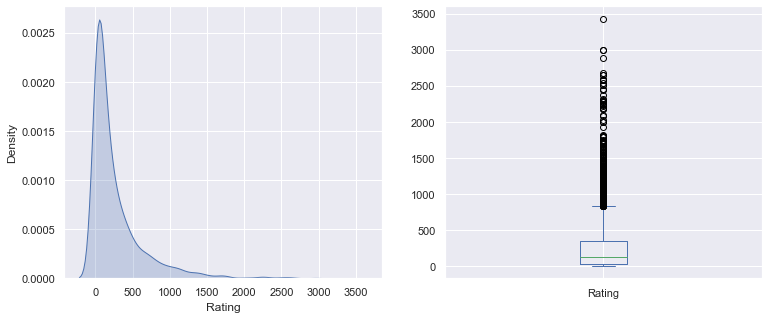

In [99]:
d1 = df2.groupby('MovieID')['Rating'].count().reset_index().sort_values('Rating', ascending=False)
plt.subplot(121)
sns.kdeplot(d1.Rating,shade=True)
plt.subplot(122)
d1.Rating.plot.box(figsize=(12.5,5))
plt.show()

## Ratings Distribution By Users

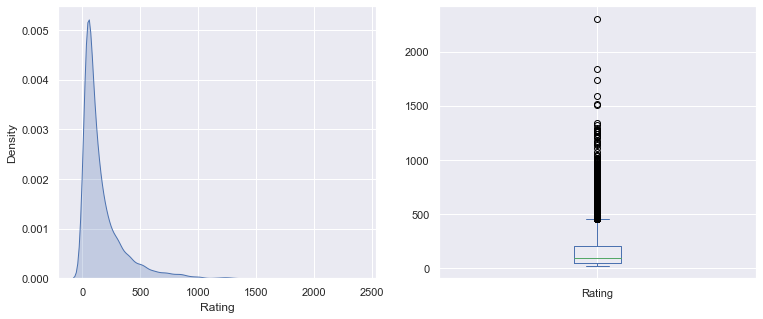

In [100]:
d2 = df2.groupby('UserID')['Rating'].count().reset_index().sort_values('Rating', ascending=False)
plt.subplot(121)
sns.kdeplot(d2.Rating,shade=True)
plt.subplot(122)
d2.Rating.plot.box(figsize=(12.5,5))
plt.show()

## `"Removing Noise from the data"`
1. To qualify a movie, a minimum of 10 users should have voted a movie.
2. To qualify a user, a minimum of 50 movies should have voted by the user.

In [101]:
no_user_voted = df2.groupby('UserID')['Rating'].agg('count')
no_movies_voted = df2.groupby('MovieID')['Rating'].agg('count')

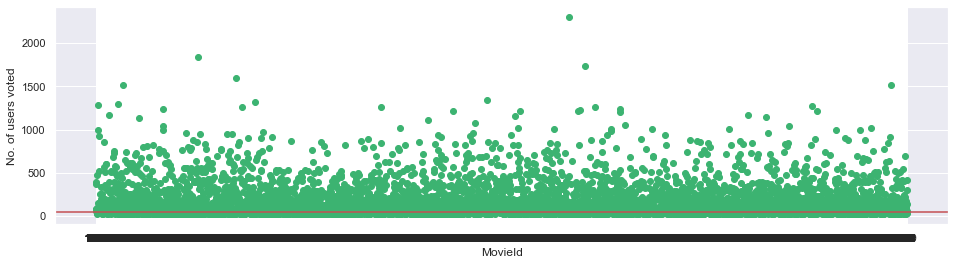

In [102]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=50,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

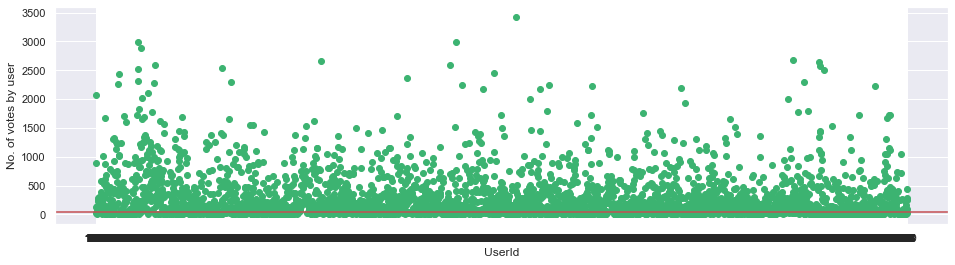

In [103]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [105]:
l1= no_user_voted[no_user_voted < 51].index.to_list()
l2= no_movies_voted[no_movies_voted < 51].index.to_list()
df2= df2[~((df2.UserID.isin(l1)) | (df2.MovieID.isin(l2) ) )]
print('Final Shape',df2.shape)

Final Shape (914835, 11)


### The above two plots share the same distribution. 
#### The number of ratings per Movie and the number of ratings per user decay exponentially.

## 3. <font color='blue'> Build a Recommender System based on Pearson Correlation.</font> 
#### 1. <font color='blue'> Creating a pivot table of movie titles & user id and imputing the NaN values</font> 

In [106]:
q1 = df2[['UserID','Title','Rating']]
data_table = pd.pivot_table(q1,values='Rating',columns='Title',index='UserID')
data_table.head()

Title,'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)",187 (1997),...,You've Got Mail (1998),Young Doctors in Love (1982),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Your Friends and Neighbors (1998),Zero Effect (1998),eXistenZ (1999)
UserID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0,4.0,NaN,...,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,5.0


In [107]:
data_table = data_table.fillna(0)
data_table.head()

Title,'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)",187 (1997),...,You've Got Mail (1998),Young Doctors in Love (1982),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Your Friends and Neighbors (1998),Zero Effect (1998),eXistenZ (1999)
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,...,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,5.0


#### 2. <font color='blue'> Use the Item-based approach to create a simple recommender system that uses Pearson Correlation</font> 

In [108]:
print("Here are a list of 10 movies to recommend to a user who has liked 'Shawshank Redemption, The (1994)'\n")
print(data_table.corr()['Shawshank Redemption, The (1994)'].sort_values(ascending=False).iloc[:10])

Here are a list of 10 movies to recommend to a user who has liked 'Shawshank Redemption, The (1994)'

Title
Shawshank Redemption, The (1994)    1.000000
Good Will Hunting (1997)            0.461405
Silence of the Lambs, The (1991)    0.458132
Pulp Fiction (1994)                 0.436558
Schindler's List (1993)             0.428404
Fargo (1996)                        0.419264
GoodFellas (1990)                   0.400021
Usual Suspects, The (1995)          0.375408
Sling Blade (1996)                  0.367897
Few Good Men, A (1992)              0.358459
Name: Shawshank Redemption, The (1994), dtype: float64


## 4. <font color='blue'> Build a Recommender System based on Cosine Similarity.</font> 
* Use the Item-based approach to create a recommender system that uses <br>Nearest Neighbors algorithm and Cosine Similarity

### <font color='blue'> Item similarity matrix</font> 

In [109]:
# Import CountVectorizer and create the count matrix
# from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(g2.Content_Type)
sim2 = cosine_similarity(count_matrix)
pd.DataFrame(sim2).round(3)

,0,1,2,3,4,5,6,7,8,9,...,3670,3671,3672,3673,3674,3675,3676,3677,3678,3679
0,1.000,0.577,0.000,0.000,0.000,0.408,0.866,0.667,0.667,0.000,...,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.000
1,0.577,1.000,0.000,0.000,0.000,0.354,0.750,0.577,0.866,0.000,...,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.000
2,0.000,0.000,1.000,0.000,0.707,0.707,0.000,0.000,0.000,0.577,...,1.000,1.000,0.0,0.000,1.000,0.0,1.000,1.000,0.0,0.707
3,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.0,0.577,0.000,0.0,0.000,0.000,0.0,0.408
4,0.000,0.000,0.707,0.000,1.000,0.500,0.000,0.000,0.000,0.408,...,0.707,0.707,0.0,0.000,0.707,0.0,0.707,0.707,0.0,0.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3675,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.0,0.000,0.000,1.0,0.000,0.000,0.0,0.000
3676,0.000,0.000,1.000,0.000,0.707,0.707,0.000,0.000,0.000,0.577,...,1.000,1.000,0.0,0.000,1.000,0.0,1.000,1.000,0.0,0.707
3677,0.000,0.000,1.000,0.000,0.707,0.707,0.000,0.000,0.000,0.577,...,1.000,1.000,0.0,0.000,1.000,0.0,1.000,1.000,0.0,0.707
3678,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,1.0,0.000


### <font color='blue'> User similarity matrix </font> 

In [133]:
user_similarity = data_table.T.corr()
user_similarity.head()


UserID,1,10,100,1000,1001,1002,1004,1005,1009,101,...,985,987,988,99,990,991,993,996,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.220591,0.102218,0.186719,0.104292,0.089390,0.133564,0.079625,0.030313,0.000474,...,0.151111,0.126150,0.181488,0.188095,0.053125,0.017689,0.049680,0.130734,0.096663,0.072840
10,0.220591,1.000000,0.214160,0.232247,0.032517,0.055945,0.324643,0.132429,0.068074,0.139614,...,0.202496,0.231046,0.143113,0.145987,0.087696,0.146143,0.080963,0.197520,0.060619,0.114953
100,0.102218,0.214160,1.000000,0.275513,0.022637,0.085925,0.186686,0.146559,0.038665,0.324496,...,0.285489,0.182764,0.164685,0.128313,0.068063,0.076748,0.162140,0.310448,0.085234,0.265599
1000,0.186719,0.232247,0.275513,1.000000,0.039859,0.019392,0.313274,0.302844,0.101015,0.254895,...,0.331196,0.083155,0.150372,0.156442,0.140409,0.052786,0.183344,0.291892,0.066140,0.193688
1001,0.104292,0.032517,0.022637,0.039859,1.000000,0.127937,0.015537,0.089173,0.175651,-0.000293,...,0.087243,0.080393,0.065012,0.158656,0.094436,-0.025337,0.085859,0.132145,0.240064,0.056717


In [277]:
# pip install --upgrade wheel

In [278]:
# pip install --upgrade setuptools

In [279]:
# pip install scikit-surprise

In [110]:
from surprise import KNNWithMeans 
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader
from sklearn.metrics import mean_absolute_percentage_error

In [111]:
data = df2[['UserID','MovieID','Rating']] #Considering only the userid, itemid and ratings
data.head()

,UserID,MovieID,Rating
0,1,1,5
1,1,48,5
2,1,150,5
3,1,260,4
4,1,527,5


In [112]:
reader = Reader(rating_scale=(1 , 5))
data = Dataset.load_from_df(data[['UserID','MovieID','Rating']], reader)

In [113]:
anti_set = data.build_full_trainset().build_anti_testset()

In [114]:
trainset, testset = train_test_split(data, test_size=.15)

### <font color='blue'> User - based collaborative filtering - Using cosine similarity </font> 

In [115]:
algo = KNNWithMeans(k = 50, sim_options={'name': 'cosine', 'user_based': True})
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [116]:
# run the trained model against the testset
test_pred = algo.test(testset)

# get RMSE on test set
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 0.9218


0.9217912068806057

### <font color='blue'> Item - based collaborative filtering - Using cosine similarity</font> 

In [117]:
algo_i = KNNWithMeans(k=50, sim_options={'name': 'cosine', 'user_based': False})
algo_i.fit(trainset)
test_pred = algo_i.test(testset)
test_pred[0]

Computing the cosine similarity matrix...
Done computing similarity matrix.


Prediction(uid='5526', iid='2912', r_ui=4.0, est=3.7939588665932753, details={'actual_k': 50, 'was_impossible': False})

In [118]:
# get RMSE on test set
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 0.8809


0.8808843449520152

## 5. <font color='blue'> Build a Recommender System based on Matrix Factorization. </font> 
* Create a Recommender System using the Matrix Factorization method.
* Pearson / user based approach give 91.5 % accuracy which is a good model.

In [119]:
from surprise import SVD
from surprise.model_selection import cross_validate

In [120]:
svd = SVD()
cross_validate(svd, data, measures=['rmse','mae'], cv = 5 , return_train_measures=True,verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8633  0.8632  0.8645  0.8656  0.8667  0.8647  0.0014  
MAE (testset)     0.6770  0.6774  0.6785  0.6790  0.6808  0.6785  0.0013  
RMSE (trainset)   0.6670  0.6667  0.6661  0.6666  0.6673  0.6667  0.0004  
MAE (trainset)    0.5273  0.5270  0.5267  0.5267  0.5274  0.5270  0.0003  
Fit time          7.90    7.86    8.75    8.15    7.89    8.11    0.33    
Test time         1.16    1.88    1.08    1.93    1.06    1.42    0.40    


{'test_rmse': array([0.86325076, 0.86321088, 0.86447802, 0.86561082, 0.86673046]),
 'train_rmse': array([0.66695875, 0.66665289, 0.66612733, 0.66662708, 0.66732518]),
 'test_mae': array([0.67701978, 0.67741996, 0.67846295, 0.67899884, 0.6807523 ]),
 'train_mae': array([0.52726661, 0.52703337, 0.52669726, 0.52668136, 0.52736879]),
 'fit_time': (7.895710229873657,
  7.863650560379028,
  8.745548009872437,
  8.145890712738037,
  7.8882575035095215),
 'test_time': (1.1645772457122803,
  1.8810923099517822,
  1.0839025974273682,
  1.9333667755126953,
  1.060394525527954)}

In [121]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [122]:
svd.pu.shape , svd.qi.shape

((4238, 100), (2485, 100))

In [123]:
#Storing all the movie titles in items
items = m['Title'].unique()
##Considering the user '662' 
test = [[662, iid, 4] for iid in items]
##Finding the user predictions(ratings) for all the movies
predictions = svd.test(test)
pred = pd.DataFrame(predictions)

In [124]:
##Sorting the values based on the estimated predictions
a = pred.sort_values(by='est', ascending=False) 
a[0:10] ##TOP 10

,uid,iid,r_ui,est,details
0,662,Schindler's List (1993),4,3.579966,{'was_impossible': False}
17,662,Braveheart (1995),4,3.579966,{'was_impossible': False}
31,662,"Fugitive, The (1993)",4,3.579966,{'was_impossible': False}
30,662,Total Recall (1990),4,3.579966,{'was_impossible': False}
29,662,Alien (1979),4,3.579966,{'was_impossible': False}
28,662,Toy Story (1995),4,3.579966,{'was_impossible': False}
27,662,"Terminator, The (1984)",4,3.579966,{'was_impossible': False}
26,662,Pulp Fiction (1994),4,3.579966,{'was_impossible': False}
25,662,Ghostbusters (1984),4,3.579966,{'was_impossible': False}
24,662,Forrest Gump (1994),4,3.579966,{'was_impossible': False}


In [125]:
testset = trainset.build_anti_testset()
predictions_svd = svd.test(testset) #Predicting for the test set

In [126]:
print('SVD - RMSE:', accuracy.rmse(predictions_svd, verbose=False))
print('SVD - MAE:', accuracy.mae(predictions_svd, verbose=False))

SVD - RMSE: 0.75474909417944
SVD - MAE: 0.5910791679661853


In [127]:
pred1 = pd.DataFrame(predictions_svd)

In [128]:
t1 = np.array(pred1.r_ui)
p1 = np.array(pred1.est)

In [129]:
print('\nMean Absolute Percentage Error :', mean_absolute_percentage_error(t1, p1))


Mean Absolute Percentage Error : 0.16510749076093595


# 6. <font color='blue'> Build a Recommender System based on Pearson Correlation. </font> 
* Use the User-based approach to create a recommender system that uses Pearson Correlation.

In [149]:
user_similarity = data_table.T.corr()
user_similarity.head()

UserID,1,10,100,1000,1001,1002,1004,1005,1009,101,...,985,987,988,99,990,991,993,996,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.220591,0.102218,0.186719,0.104292,0.089390,0.133564,0.079625,0.030313,0.000474,...,0.151111,0.126150,0.181488,0.188095,0.053125,0.017689,0.049680,0.130734,0.096663,0.072840
10,0.220591,1.000000,0.214160,0.232247,0.032517,0.055945,0.324643,0.132429,0.068074,0.139614,...,0.202496,0.231046,0.143113,0.145987,0.087696,0.146143,0.080963,0.197520,0.060619,0.114953
100,0.102218,0.214160,1.000000,0.275513,0.022637,0.085925,0.186686,0.146559,0.038665,0.324496,...,0.285489,0.182764,0.164685,0.128313,0.068063,0.076748,0.162140,0.310448,0.085234,0.265599
1000,0.186719,0.232247,0.275513,1.000000,0.039859,0.019392,0.313274,0.302844,0.101015,0.254895,...,0.331196,0.083155,0.150372,0.156442,0.140409,0.052786,0.183344,0.291892,0.066140,0.193688
1001,0.104292,0.032517,0.022637,0.039859,1.000000,0.127937,0.015537,0.089173,0.175651,-0.000293,...,0.087243,0.080393,0.065012,0.158656,0.094436,-0.025337,0.085859,0.132145,0.240064,0.056717


### We first need to exclude user ID 662 from the similar user list and decide the number <br>of similar users.
1. In the user similarity matrix, the values range from -1 to 1, where -1 means opposite <br>movie preference and 1 means same movie preference.
2. n = 10 means we would like to pick the top 10 most similar users for user ID 1.
3. The user_similarity_threshold to be 0.3, meaning that a user must have a Pearson correlation <br>coefficient of at least 0.3 to be considered as a similar user.

In [150]:
# Pick a user ID
picked_userid = '662'
# Remove picked user ID from the candidate list
user_similarity.drop(index=picked_userid, inplace=True)
# Take a look at the data
user_similarity.head()

UserID,1,10,100,1000,1001,1002,1004,1005,1009,101,...,985,987,988,99,990,991,993,996,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.220591,0.102218,0.186719,0.104292,0.089390,0.133564,0.079625,0.030313,0.000474,...,0.151111,0.126150,0.181488,0.188095,0.053125,0.017689,0.049680,0.130734,0.096663,0.072840
10,0.220591,1.000000,0.214160,0.232247,0.032517,0.055945,0.324643,0.132429,0.068074,0.139614,...,0.202496,0.231046,0.143113,0.145987,0.087696,0.146143,0.080963,0.197520,0.060619,0.114953
100,0.102218,0.214160,1.000000,0.275513,0.022637,0.085925,0.186686,0.146559,0.038665,0.324496,...,0.285489,0.182764,0.164685,0.128313,0.068063,0.076748,0.162140,0.310448,0.085234,0.265599
1000,0.186719,0.232247,0.275513,1.000000,0.039859,0.019392,0.313274,0.302844,0.101015,0.254895,...,0.331196,0.083155,0.150372,0.156442,0.140409,0.052786,0.183344,0.291892,0.066140,0.193688
1001,0.104292,0.032517,0.022637,0.039859,1.000000,0.127937,0.015537,0.089173,0.175651,-0.000293,...,0.087243,0.080393,0.065012,0.158656,0.094436,-0.025337,0.085859,0.132145,0.240064,0.056717


In [151]:
# Number of similar users
n = 10
# User similarity threashold
user_similarity_threshold = 0.3
# Get top n similar users
similar_users = user_similarity[user_similarity[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]
# Print out top n similar users
print(f'The similar users for user {picked_userid} are', similar_users)

The similar users for user 662 are UserID
3715    0.406883
1850    0.394421
3979    0.363503
4086    0.361890
2995    0.352293
1938    0.352291
6004    0.349787
5558    0.348955
2180    0.343098
271     0.342484
Name: 662, dtype: float64


##### We will narrow down the item pool by doing the following:
1. Remove the movies that have been watched by the target user (user ID 424 in this example).
2. Keep only the movies that similar users have watched.

In [152]:
# Movies that the target user has watched
picked_userid_watched = data_table[data_table.index == picked_userid].dropna(axis=1, how='all')
picked_userid_watched

Title,'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)",187 (1997),...,You've Got Mail (1998),Young Doctors in Love (1982),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Your Friends and Neighbors (1998),Zero Effect (1998),eXistenZ (1999)
UserID,,,,,,,,,,,,,,,,,,,,,
662,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* To keep only the similar users’ movies, we keep the user IDs in the top 10 similar user lists <br>and remove the film with all missing values. 
* All missing value for a movie means that none of the similar users have watched the movie.

In [156]:
# Movies that similar users watched. Remove movies that none of the similar users have watched
similar_user_movies = data_table[data_table.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_movies

Title,'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)",187 (1997),...,You've Got Mail (1998),Young Doctors in Love (1982),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Your Friends and Neighbors (1998),Zero Effect (1998),eXistenZ (1999)
UserID,,,,,,,,,,,,,,,,,,,,,
1850,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
2180,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0
271,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,4.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2995,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
3715,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3979,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4086,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,...,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5558,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [158]:
# # Remove the watched movie from the movie list
# similar_user_movies.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')
# # Take a look at the data
# similar_user_movies

In [157]:
# A dictionary to store item scores
item_score = {}
# Loop through items
for i in similar_user_movies.columns:
  # Get the ratings for movie i
  movie_rating = similar_user_movies[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the movie has rating
    if pd.isna(movie_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the movie rating
      score = similar_users[u] * movie_rating[u]
      # Add the score to the total score for the movie so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total / count
# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['movie', 'movie_score'])
    
# Sort the movies by score
ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)
# Select top m movies
m = 10
ranked_item_score.head(m)

,movie,movie_score
219,Beauty and the Beast (1991),1.529121
1295,"Little Mermaid, The (1989)",1.529059
1291,"Lion King, The (1994)",1.494142
2188,"Sword in the Stone, The (1963)",1.490014
66,Aladdin (1992),1.458913
1422,Men in Black (1997),1.458016
2123,Star Wars: Episode IV - A New Hope (1977),1.414968
1896,Robin Hood (1973),1.384012
667,E.T. the Extra-Terrestrial (1982),1.383261
1038,Hercules (1997),1.350851


In [163]:
# Average rating for the picked user
avg_rating = data_table[data_table.index == picked_userid].T.mean()[picked_userid]
# Print the average movie rating for user 1
print(f'The average movie rating for user {picked_userid} is {avg_rating:.2f}')

The average movie rating for user 662 is 0.16


In [164]:
# Calcuate the predicted rating
ranked_item_score['predicted_rating'] = ranked_item_score['movie_score'] + avg_rating
# Take a look at the data
ranked_item_score.head(m)

,movie,movie_score,predicted_rating
219,Beauty and the Beast (1991),1.529121,1.689282
1295,"Little Mermaid, The (1989)",1.529059,1.689220
1291,"Lion King, The (1994)",1.494142,1.654303
2188,"Sword in the Stone, The (1963)",1.490014,1.650175
66,Aladdin (1992),1.458913,1.619074
1422,Men in Black (1997),1.458016,1.618177
2123,Star Wars: Episode IV - A New Hope (1977),1.414968,1.575129
1896,Robin Hood (1973),1.384012,1.544173
667,E.T. the Extra-Terrestrial (1982),1.383261,1.543422
1038,Hercules (1997),1.350851,1.511012


### ------------------------------------------------------------------------------------------------

## Questionnaire:

<font color='blue'>
<br>
1. Users of which age group have watched and rated the most number of movies? 
<br>* Ans : 25-34 age group
<br>
<br>2. Users belonging to which profession have watched and rated the most movies? 
<br>* Ans: college/grad student
<br>
<br>3. Most of the users in our dataset who’ve rated the movies are Male. (T/F)
<br>* Ans: True
<br>
<br>4. Most of the movies present in our dataset were released in which decade? <br>70s b. 90s c. 50s d.80s
<br>* Ans:90s. Year group [1991- 2000]
<br>
<br>5. The movie with maximum no. of ratings is :  "American Beauty (1999)".
<br>
<br>6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.
<br>* Ans:<br>1. Airplane! (1980)<br>2. Ferris Bueller's Day Off (1986)<br>3. Moonstruck (1987)
<br>
<br>7. On the basis of approach, Collaborative Filtering methods can be classified into "Item"-based and "User"-based.
<br>
<br>8. Pearson Correlation ranges between -1 to 1 whereas, Cosine Similarity belongs to the interval between 0 to 1.

<br>9. Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.
<br>* Ans:RMSE = 0.75,  MAPE = 0.16

<br>10. Give the sparse ‘row’ matrix representation for the following dense matrix -

[[1 0]
[3 7]]
</font>

In [132]:
csr_sample = csr_matrix([[1,0], [3,7]])
print('Sparse ‘row’ matrix representation\n')
print(csr_sample)

Sparse ‘row’ matrix representation

  (0, 0)	1
  (1, 0)	3
  (1, 1)	7
